In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/human-stress-prediction/Stress.csv


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



# **Importing data**

In [75]:
stress_data_path ='../input/human-stress-prediction/Stress.csv'
stress_data = pd.read_csv(stress_data_path)

# Exploratory Data Analysis

In [76]:
print("First rows of the dataset: \n")
print(stress_data.head())

First rows of the dataset: 

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge...      1         0.8   
1  Hey there r/assistance, Not sure if this is th...      0         1.0   
2  My mom then hit me with the newspaper and it s...      1         0.8   
3  until i met my new boyfriend, he is amazing, h...      1         0.6   
4  October is Domestic Violence Awareness Month a...      1         0.8   

   social_timestamp  
0        1521614353  
1        1527009817  
2        1535935605  
3        1516429555  
4        1539809005  


In [77]:
print("Example post in the dataset: \n")
print(stress_data['text'].iloc[128])

Example post in the dataset: 

(I should note, our first year together we went to the Maldives, second year we bought a house & went to Croatia, Venice, Belgium, Lots of weekends away - I'm not exactly lacking trips away) *I'm content and rarely feel unhappy these days, but is that a replacement of happiness? * Is this just a January blues thing that will go as the year starts moving on and I get back into the swing of things? ---


In [84]:
# Basic statistics in terms of characters
post_char_lengths = stress_data.text.apply(len)
print("\nBasic statistics of post lengths (in characters): \n")
char_statistics = post_lengths.describe()
print(char_statistics)

# Calculate the length of each post in terms of words
stress_data['word_length'] = stress_data['text'].apply(lambda post: len(post.split())) # Store to new column
post_word_lengths = stress_data['word_length']
print("\nBasic statistics of post lengths (in words): \n")
word_statistics = post_word_lengths.describe()
print(word_statistics)



Basic statistics of post lengths (in characters): 

count    2838.000000
mean      447.996476
std       168.929122
min         6.000000
25%       339.000000
50%       421.000000
75%       528.750000
max      1639.000000
Name: text, dtype: float64

Basic statistics of post lengths (in words): 

count    2838.000000
mean       85.669838
std        32.292305
min         1.000000
25%        65.000000
50%        80.000000
75%       101.000000
max       310.000000
Name: word_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


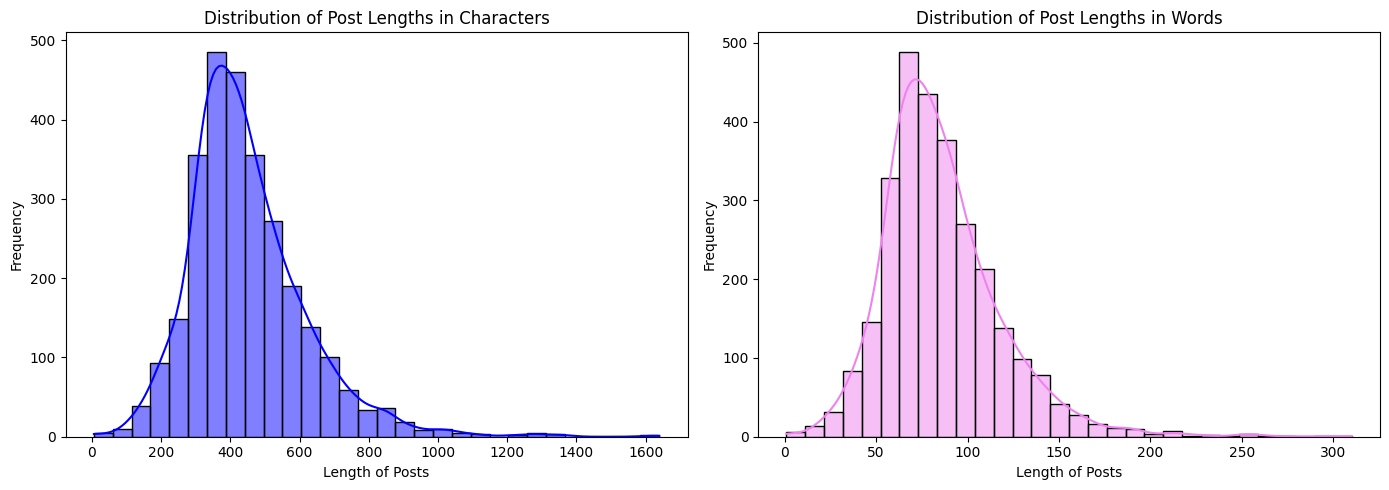

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# Distribution of post lengths in words
plt.subplot(1, 2, 1)
sns.histplot(post_char_lengths, kde=True, bins=30, color='blue')
plt.title('Distribution of Post Lengths in Characters')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

# Distribution of post lengths in characters
plt.subplot(1, 2, 2)
sns.histplot(post_word_lengths, kde=True, bins=30, color='violet')
plt.title('Distribution of Post Lengths in Words')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()


*We can observe that the most posts range in length from 200 to 800 in characters, or 50 to 150 in words.*

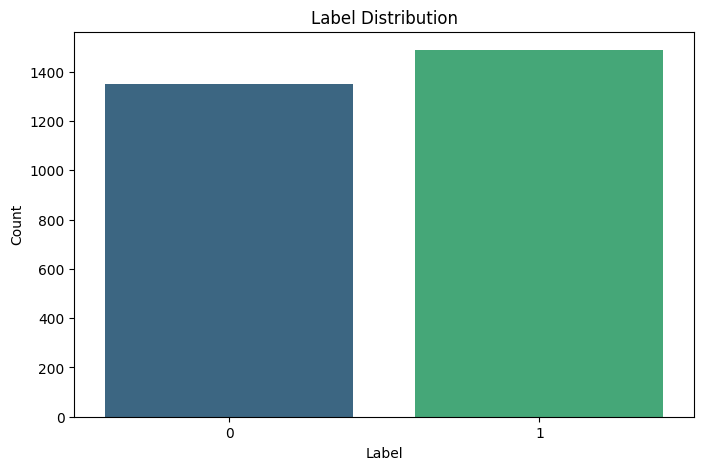

In [80]:
# Label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=stress_data, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

*We can observe that the dataset is balanced, with respect to the class we want to predict.*

# Removing detected outliers


Number of outliers below lower bound (Q1 - 1.5 * IQR): 6
Number of outliers above upper bound (Q3 + 1.5 * IQR): 87
Lower bound (Q1 - 1.5 * IQR): 11.0, Upper bound (Q3 + 1.5 * IQR): 155.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


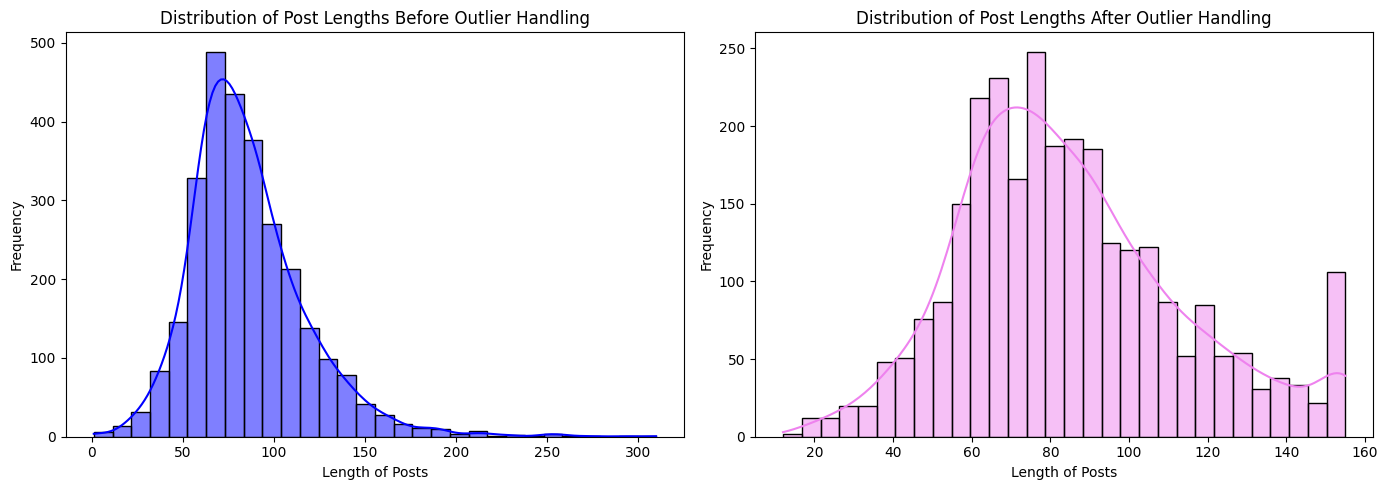

In [93]:
# Calculate interquartile range (IQR)
Q1 = word_statistics['25%']
Q3 = word_statistics['75%']
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the original DataFrame
filtered_data = stress_data.copy()

# Iterate through each row
for index, row in filtered_data.iterrows():
    if row['word_length'] > upper_bound:
        # Truncate posts longer than upper_bound
        filtered_data.at[index, 'text'] = ' '.join(row['text'].split()[:int(upper_bound)])

# Remove posts below lower bound
filtered_data = filtered_data[filtered_data['word_length'] >= lower_bound]

# Print information about outliers
outliers_below = stress_data[stress_data['word_length'] < lower_bound]
outliers_above = stress_data[(stress_data['word_length'] > upper_bound)]
print(f"\nNumber of outliers below lower bound (Q1 - 1.5 * IQR): {outliers_below.shape[0]}")
print(f"Number of outliers above upper bound (Q3 + 1.5 * IQR): {outliers_above.shape[0]}")
print(f"Lower bound (Q1 - 1.5 * IQR): {lower_bound}, Upper bound (Q3 + 1.5 * IQR): {upper_bound}")

# Plot the distribution of post lengths before and after removing outliers
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(stress_data['word_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Post Lengths Before Outlier Handling')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(filtered_data['text'].apply(lambda x: len(x.split())), kde=True, bins=30, color='violet')
plt.title('Distribution of Post Lengths After Outlier Handling')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


*We can observe that we achieved a better distribution of post's lengths in terms of words by removing lower outliers and truncating upper outliers.*

# **Text Preprocessing**

In [ ]:

#removing special characters 
#def remove_spec(text):
 #   return re.sub(r'[^a-zA-Z0-9\s]', '', text)

#clean_posts = list(map(remove_spec, stress_data.text))


In [6]:
import spacy
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(post):
    doc = nlp(post) #fit the spacy model
    
    clean_tokens = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue #do not include punctuation chars and stopwords
        clean_tokens.append(token.lemma_)
    
    return clean_tokens


In [ ]:
data[0]

In [7]:
tokenized_data = []
label_data = []
for post,label in data: 
    tokenized_post = preprocess_and_vectorize(post)
    if tokenized_post:
        tokenized_data.append(tokenized_post)
        label_data.append(label)


# A sprinkle of Data Visualization

In [ ]:
# extract input texts with label 1
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 1]  #traverse the list as list of tuples 

# generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts)) #join strings into one 

# plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()



In [ ]:
# extract input texts with label 0
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 0]

# generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts))

# plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()


In [ ]:
print(tokenized_data[0])
print(label_data[0])


# **Splitting Data**

In [8]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_data, 
    label_data, 
    train_size=0.8, 
    random_state=4
)



In [73]:
##X = clean_posts #attributes according to which we classify
#y = stress_data.label #class
# Convert X and y to NumPy arrays

# Initialize the stratified k-fold cross-validation object
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#split_data = skf.split(X, y)

Vectorizing train data

# **Bag of Words**

# create the transform
tf_vectorizer=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,1))

# tokenize and build vocab
bow_train = tf_vectorizer.fit_transform(X_train)
# encode document
bow_test = tf_vectorizer.transform(X_test)
# summarize
#print(sorted(vectorizer.vocabulary_))
print('BOW train: ',bow_train.shape)
print('BOW test: ',bow_test.shape)

print(len(vectorizer.idf_))

# summarize encoded vector
print(vectorized_posts[0].shape)
print(vectorized_posts[0].toarray())


In [74]:
#print(len(vectorized_posts))
#print(len(stress_data))


# **Bag of N-Grams**

# create the transform
tf_vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(7, 7)) #instead of separate words treat them as 7-grams, groups of len 7
# tokenize and build vocab
bon_train = tf_vectorizer2.fit_transform(X_train)

# encode document
bon_test = tf_vectorizer2.transform(X_test)
# summarize
#print(sorted(vectorizer.vocabulary_))
print('BON train: ',bow_train.shape)
print('BON test: ',bow_test.shape)



# **Generating embeddings**

In [9]:
#vectorized_w2v = [gensim.utils.simple_preprocess(text) for text in clean_posts]
#len(vectorized_w2v)

wv = api.load("glove-twitter-25")


[==================================================] 100.0% 104.8/104.8MB downloaded


In [76]:
wv.get_mean_vector(X_train[2])


array([-0.07963082,  0.02786993, -0.1118979 ,  0.07432982,  0.06536698,
        0.00142367,  0.09981715, -0.21375556,  0.06222064,  0.04254569,
        0.02311464,  0.09475099, -0.5490071 ,  0.01281391,  0.07900295,
        0.06116072,  0.04513504,  0.00119624,  0.04749446, -0.08894351,
       -0.07666157,  0.10886507,  0.12574716, -0.00554666, -0.09551053],
      dtype=float32)

In [77]:
len(wv.get_vector(X_train[2][0]))

25

In [10]:
wv_train_data = []
for tokenized_post in X_train:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_train_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post
#wv_train_data[2]

wv_train_data2 = []
for tokenized_post in X_train:
    if tokenized_post:  #some may be empty bcs of stopword removal
        vectorized_post = [wv.get_vector(word) for word in tokenized_post if word in wv]  #get vector for each word
        wv_train_data2.append(vectorized_post)  #append the list of vectors to wv_train_data

#wv_train_data[2]


In [25]:
len(wv_train_data[5]) #vector size for each post 

24

# **Naive Bayes**

* word2vec 0.6948853615520282


In [18]:
gnb = GaussianNB()
# Average word vectors for each post
X_train_avg = []
for vectorized_post in wv_train_data:
    if vectorized_post.all():  # Ensure the post has vectors
        avg_vector = wv.get_mean_vector(vectorized_post) # Average the vectors
        X_train_avg.append(avg_vector)

X_train_avg = np.array(X_train_avg)
gnb.fit(wv_train_data, y_train)


AttributeError: 'list' object has no attribute 'all'

In [17]:
wv_test_data = []
for tokenized_post in X_test:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_test_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post
prediction = gnb.predict(wv_test_data)
gnb_score=accuracy_score(y_test,prediction)
print("gnb_score :",gnb_score)

NotFittedError: This GaussianNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# LSTM :)

In [17]:
len(wv_train_data[465])

25

In [13]:
vocab_size = len(wv.key_to_index)
input_length = len(wv_train_data[0])
embedding_length = 10

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Example: Assuming you have word embeddings and tokenized sequences X_train, X_test and corresponding labels y_train, y_test
# Also assuming you have word embeddings wv and the parameters vocab_size, embedding_length, input_length

# Define LSTM model
model = Sequential()
# Assuming each post is represented as a sequence of word vectors, and each vector has length `embedding_length`
model.add(LSTM(128, input_shape=(input_length, embedding_length), return_sequences=True, dropout=0.5, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True, dropout=0.6, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# compile model
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Example: Convert y_train and y_test to numpy arrays if they are not already in that format
y_train2 = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test2 = np.asarray(y_test).astype('float32').reshape((-1,1))

# Example: Convert wv_train_data and wv_test_data to numpy arrays for model training and evaluation
wv_train_data = wv_train_data2

# Pad sequences to a fixed length
max_len = 20  # Example: Set maximum length of posts
wv_train_data_padded = pad_sequences(wv_train_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# train model
model.fit(wv_train_data_padded, y_train2, epochs=30, batch_size=32, callbacks=[cp])

# Prepare wv_test_data and pad sequences
wv_test_data = []
for tokenized_post in X_test:
    vectorized_post = [wv.get_vector(word) for word in tokenized_post if word in wv]
    wv_test_data.append(vectorized_post)

wv_test_data_padded = pad_sequences(wv_test_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# evaluate model
loss, accuracy = model.evaluate(wv_test_data_padded, y_test2)
print("Test Accuracy:", accuracy)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 128)           71168     
                                                                 
 batch_normalization (Batch  (None, 25, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 25, 128)           131584    
                                                                 
 batch_normalization_1 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 25, 64)            8256      
                                                                 
 dense_1 (Dense)             (None, 25, 1)            

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 25, 10), found shape=(None, 20, 25)


In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout, Input, BatchNormalization, Bidirectional
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model/', save_best_only = True)

# Assuming you have tokenized sequences X_train and X_test and corresponding labels y_train, y_test
# Also, assuming you have word embeddings wv

# Define LSTM model
model = Sequential()
#model.add(Input(shape=(len(wv_train_data[0]), 1)))
model.add(Embedding(vocab_size, embedding_length, input_length = input_length))
model.add(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True, dropout=0.6, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# compile model
model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])

y_train2 = np.asarray(y_train).astype('float32').reshape((-1,1))

# train model
model.fit(np.array(wv_train_data), y_train2, epochs=30, batch_size=32)
          
wv_test_data = []
for tokenized_post in X_test:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_test_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post

# evaluate model
y_test2 = np.asarray(y_test).astype('float32').reshape((-1,1))

loss, accuracy = model.evaluate(np.array(wv_test_data), y_test2)
print("Test Accuracy:", accuracy)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 10)            11935140  
                                                                 
 lstm_2 (LSTM)               (None, 25, 128)           71168     
                                                                 
 batch_normalization_2 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 25, 128)           131584    
                                                                 
 batch_normalization_3 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 25, 64)           

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2267,) + inhomogeneous part.

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Initialize variables to store the total accuracy across all folds
total_accuracy = 0.0

# Iterate over the folds
for train_index, test_index in split_data:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    gnb.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = gnb.predict(X_test)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)

    # Accumulate accuracy for all folds
    total_accuracy += fold_accuracy

    # Print accuracy for this fold
    print("Accuracy for this fold:", fold_accuracy)

# Calculate average accuracy across all folds
average_accuracy = total_accuracy / skf.n_splits

print("Average Accuracy:", average_accuracy)



# initialize the naive bayes classifier
gnb1 = GaussianNB()
gnb2 = GaussianNB()

#fitting the nb for bag of words
gnb_bow=gnb1.fit(bow_train.toarray(), y_train)
print(gnb_bow)
#fitting the nb for tfidf features
gnb_bon=gnb2.fit(bon_train.toarray(), y_train)
print(gnb_bon)


#Predicting the model for bag of words
gnb_bow_predict = gnb_bow.predict(bow_test.toarray())

#Predicting the model for bag of ngrams
gnb_bon_predict = gnb_bon.predict(bon_test.toarray())


#Accuracy score for bag of words
gnb_bow_score=accuracy_score(y_test,gnb_bow_predict)
print("gnb_bow_score :",gnb_bow_score)
#Accuracy score for tfidf features
gnb_bon_score=accuracy_score(y_test,gnb_bon_predict)
print("gnb_bon_score :",gnb_bon_score)

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import spacy
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.optimizers import Adam

# Load dataset
stress_data_path = '../input/human-stress-prediction/Stress.csv'
stress_data = pd.read_csv(stress_data_path)

# Preprocessing function
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(post):
    doc = nlp(post)
    clean_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return clean_tokens

# Tokenize posts
posts = stress_data['text'].tolist()
labels = stress_data['label'].tolist()
data = list(zip(posts, labels))

tokenized_data = []
label_data = []
for post, label in data: 
    tokenized_post = preprocess_and_vectorize(post)
    if tokenized_post:
        tokenized_data.append(tokenized_post)
        label_data.append(label)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, label_data, train_size=0.8, random_state=4)

# Load word vectors
wv = api.load("glove-twitter-25")
embedding_dim = wv.vector_size


TypeError: vectorize_data() missing 1 required positional argument: 'embed_size'

In [30]:
# Convert tokens to vectors
def vectorize_data(tokenized_data, wv, embed_size):
    vectorized_data = []
    for tokenized_post in tokenized_data:
        vectorized_post = []
        for word in tokenized_post:
            if word in wv:
                vectorized_post.append(wv.get_vector(word))
            else:
                # Assign random values if word is out of vocabulary
                random_vector = np.random.normal(size=embed_size)
                vectorized_post.append(random_vector)
        if vectorized_post:
            vectorized_data.append(np.array(vectorized_post))
    return vectorized_data

wv_train_data2 = vectorize_data(X_train, wv, embedding_dim)
wv_test_data2 = vectorize_data(X_test, wv, embedding_dim)

# Ensure labels are numpy arrays
y_train2 = np.asarray(y_train).astype('float32').reshape((-1, 1))
y_test2 = np.asarray(y_test).astype('float32').reshape((-1, 1))

In [31]:
from keras.preprocessing.sequence import pad_sequences

# Pad sequences
max_len = max(max(len(seq) for seq in wv_train_data2), max(len(seq) for seq in wv_test_data2))
wv_train_data2 = pad_sequences(wv_train_data2, maxlen=max_len, dtype='float32', padding='post', truncating='post')
wv_test_data2 = pad_sequences(wv_test_data2, maxlen=max_len, dtype='float32', padding='post', truncating='post')


In [38]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(None, embedding_dim), dropout=0.5, recurrent_dropout=0.25))
model.add(LSTM(128, return_sequences=False, dropout=0.5, recurrent_dropout=0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, None, 128)         78848     
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 218753 (854.50 KB)
Trainable params: 218753 (854.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test Accuracy: 0.5061728395061729


In [39]:
model.fit(wv_train_data2, y_train2, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
15/15 [==============================] - 21s 931ms/step - loss: 0.6929 - accuracy: 0.5207 - val_loss: 0.6914 - val_accuracy: 0.5330
Epoch 2/10
15/15 [==============================] - 14s 921ms/step - loss: 0.6910 - accuracy: 0.5279 - val_loss: 0.6913 - val_accuracy: 0.5330
Epoch 3/10
15/15 [==============================] - 13s 878ms/step - loss: 0.6923 - accuracy: 0.5119 - val_loss: 0.6916 - val_accuracy: 0.5330
Epoch 4/10
15/15 [==============================] - 13s 886ms/step - loss: 0.6918 - accuracy: 0.5279 - val_loss: 0.6908 - val_accuracy: 0.5330
Epoch 5/10
15/15 [==============================] - 14s 922ms/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6911 - val_accuracy: 0.5330
Epoch 6/10
15/15 [==============================] - 13s 895ms/step - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6914 - val_accuracy: 0.5330
Epoch 7/10
15/15 [==============================] - 14s 923ms/step - loss: 0.6908 - accuracy: 0.5268 - val_loss: 0.6910 - val_accuracy: 0.5330

In [41]:
loss, accuracy = model.evaluate(wv_test_data2, y_test2)
print("Test Accuracy:", accuracy)

18/18 [==============================] - 1s 60ms/step - loss: 0.6920 - accuracy: 0.5062
Test Accuracy: 0.5061728358268738
